# OWG Policy in Pybullet

In [1]:
cd ..

/home/owner/OWG


In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Setup Pybullet Env

In [3]:
from owg_robot.env import *
from owg_robot.camera import Camera
from owg_robot.objects import YcbObjects

pybullet build time: Apr 22 2025 20:50:03


In [4]:
#p.disconnect()

# load camera and env
center_x, center_y, center_z = CAM_X, CAM_Y, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (448, 448), 40)
env = Environment(camera, vis=True, asset_root='./owg_robot/assets', debug=False, finger_length=0.06)

# load objects
objects = YcbObjects('./owg_robot/assets/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'],
                    seed=42
)
objects.shuffle_objects()

n_objects = 12

for obj_name in objects.obj_names[:n_objects]:
    path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
    env.load_isolated_obj(path, obj_name, mod_orn, mod_stiffness)
env.dummy_simulation_steps(10)

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 570.86.15
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 570.86.15
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

b3Printf: PosixSharedMemory::releaseSharedMemory removed sh

In [5]:
!pip install scikit-image


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from third_party.grconvnet import *
from owg.utils.grasp import Grasp2D
import sys

sys.path.append('/home/owner/OWG/third_party/grconvnet')
grasp_generator = load_grasp_generator(camera)

PROJECT_ROOT: /home/owner/OWG/third_party
Trying to load: /home/owner/OWG/third_party/grconvnet/checkpoints/GR_ConvNet/cornell-randsplit-rgbd-grconvnet3-drop1-ch32/epoch_19_iou_0.98


INFO:root:CUDA detected. Running with GPU acceleration.


224 224


<Figure size 1000x1000 with 0 Axes>

In [7]:
def setup_grasps(env, grasp_generator, visualise_grasps=False):
        rgb, depth, seg = env.camera.get_cam_img()    
        img_size = grasp_generator.IMG_WIDTH
        if  img_size != camera.width: 
            print("RGB type:", type(rgb), "shape:", getattr(rgb, "shape", "N/A"))
            print("Depth type:", type(depth), "shape:", getattr(depth, "shape", "N/A"))
            rgb = cv2.resize(rgb, (img_size, img_size))
            depth = cv2.resize(depth, (img_size, img_size))
        for obj_id in env.obj_ids:
            mask = seg == obj_id
            if img_size != camera.width:
                mask = np.array(Image.fromarray(mask).resize((img_size, img_size), Image.LANCZOS))
            grasps, grasp_rects = grasp_generator.predict_grasp_from_mask(rgb,
                                                           depth,
                                                           mask,
                                                           n_grasps=5, 
                                                           show_output=True
            )
            if img_size != camera.width:
                # normalize to original size
                for j, gr in enumerate(grasp_rects):
                    grasp_rects[j][0] = int(gr[0] / img_size * camera.width)
                    grasp_rects[j][1] = int(gr[1] / img_size * camera.width)
                    grasp_rects[j][4] = int(gr[4] / img_size * camera.width)
                    grasp_rects[j][3] = int(gr[3] / img_size * camera.width)
            grasp_rects = [Grasp2D.from_vector(
                x=g[1], y=g[0], w=g[4], h=g[3], theta=g[2], W=camera.width, H=camera.width, normalized=False, line_offset=5,
            ) for g in grasp_rects]
            env.set_obj_grasps(obj_id, grasps, grasp_rects)
        
        if visualise_grasps:
            LID =[]
            for obj_id in env.obj_ids:
                grasps = env.get_obj_grasps(obj_id)
                color = np.random.rand(3).tolist()
                for g in grasps:
                    LID = env.draw_predicted_grasp(g,color=color,lineIDs=LID)
            
            time.sleep(1)
            env.remove_drawing(LID)
            env.dummy_simulation_steps(10)

In [8]:
# run and visualize grasps -- check in your Pybullet client
setup_grasps(env, grasp_generator, visualise_grasps=True)

RGB type: <class 'numpy.ndarray'> shape: (448, 448, 3)
Depth type: <class 'numpy.ndarray'> shape: (448, 448)
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug draw failed
b3Printf: b3Warning[examples/SharedMemory/PhysicsClientSharedMemory.cpp,1305]:

b3Printf: User debug

<Figure size 640x480 with 0 Axes>

In [9]:
obs = env.get_obs()

all_grasp_rects = {k: env.get_obj_grasp_rects(k) for k in env.obj_ids }

## Referring Segmentation

In [ ]:
from getpass import getpass

openai_api_key = getpass()
os.environ['OPENAI_API_KEY'] = openai_api_key

In [11]:
from owg.visual_prompt import VisualPrompterGrounding, VisualPrompterPlanning, VisualPrompterGraspRanking

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
config_path = 'config/pyb/OWG.yaml'

In [13]:
grounder = VisualPrompterGrounding(config_path, debug=True)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [14]:
image, seg = obs['image'], obs['seg']
obj_ids = np.unique(seg)[1:]
all_masks = np.stack([seg == objID for objID in obj_ids])
marker_data = {'masks': all_masks, 'labels': obj_ids}

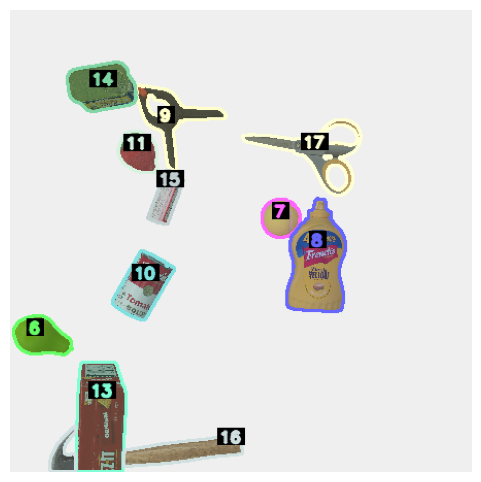

In [15]:
# show visual prompt
visual_promppt, _ = grounder.prepare_image_prompt(image.copy(), marker_data)
marked_image_grounding = visual_promppt[-1]
display_image(marked_image_grounding, (6,6))

In [16]:
# GPT request
user_query = "I want to cut some paper"

dets, target_mask, target_ids = grounder.request(text_query=user_query,image=image.copy(),data=marker_data)

GPT response:
To cut paper, you would need scissors. In the image, the scissors are located on the right side.

In the marked image, the scissors are labeled with ID 17.

My final answer is: [17]



17


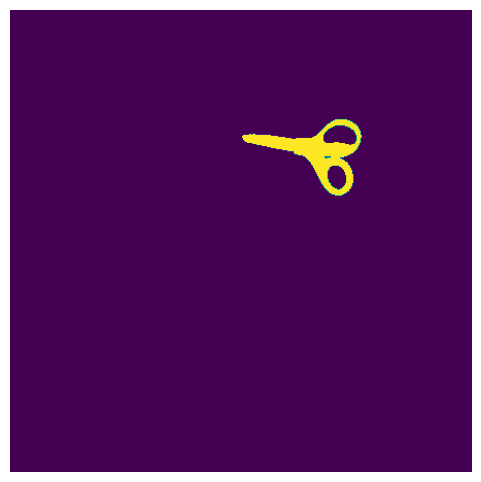

In [17]:
target_id = target_ids[0] # assume single correct object
print(target_id)
display_image(target_mask, (6,6))

## Grasp Planning

In [18]:
planner = VisualPrompterPlanning(config_path, debug=True)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [19]:
plan = planner.request(text_query=target_id,
                                    image=image.copy(),
                                    data=marker_data)
action = plan[0]

GPT response:
Plan:
```json
[
  {"action": "pick", "input": 17}
]
```



In [20]:
action

{'action': 'pick', 'input': 17}

## Grasp Ranking

In [21]:
grasp_ranker = VisualPrompterGraspRanking(config_path, debug=True)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [25]:
obj_grasps = all_grasp_rects[action['input']]
obj_mask = all_masks[np.where(obj_ids == action['input'])[0][0]]  # Get index safely
req_data = {'grasps': obj_grasps, 'mask': obj_mask}

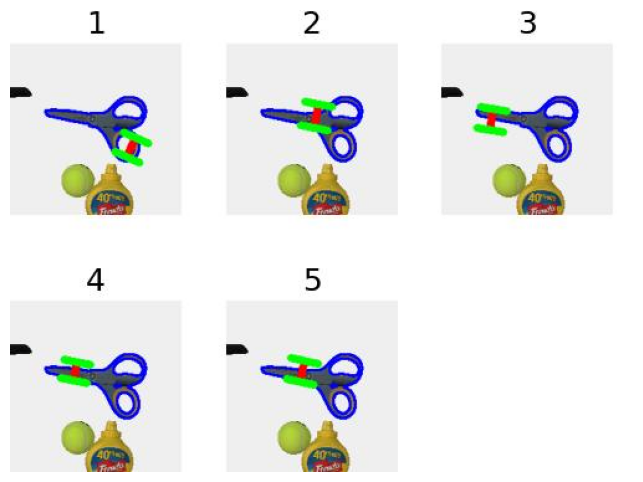

In [26]:
# show visual prompt
visual_prompt, _ = grasp_ranker.prepare_image_prompt(image.copy(), req_data)
marked_image_grasping = visual_prompt[-1]
display_image(marked_image_grasping, (12,6))

In [27]:
sorted_grasps, best_grasp, sorted_grasp_indices = grasp_ranker.request(image.copy(), req_data)

GPT response:
1) The object of interest is a pair of blue scissors. The surrounding objects are a green ball and a bottle.

2) Grasp poses leading to contacts:
   - Pose 1: Contact with the green ball.
   - Pose 2: Contact with the green ball.
   - Pose 3: No contact.
   - Pose 4: No contact.
   - Pose 5: Contact with the bottle.

3) Ranking of grasp poses from best to worst:
   - Pose 4: No contact, close to the center.
   - Pose 3: No contact, slightly off-center.
   - Pose 5: Contact with the bottle.
   - Pose 1: Contact with the green ball.
   - Pose 2: Contact with the green ball.

My final answer is: [4, 3, 5, 1, 2].



In [28]:
action['grasps'] = sorted_grasp_indices

In [29]:
        # take step
        if action['action'] == 'remove':
            success_grasp, success_target = env.put_obj_in_free_space(
                action['input'], grasp_indices=action['grasps'])
        elif action['action'] == 'pick':
            success_grasp, success_target = env.put_obj_in_tray(
                action['input'], grasp_indices=action['grasps'])
        for _ in range(30):
            env.step_simulation()
        print(success_grasp, success_target)

True True


In [30]:
p.disconnect()

b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
